OSCILADOR ARMÓNICO AMORTIGUADO FORZADO: ¿Cuándo aparece el caos?

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy as scipy
from math import *

VALORES NUMÉRICOS DEL PROBLEMA

Condiciones iniciales

In [2]:
x_0 = 1 # Posición inicial (arb)
v_0 = 0 # Velocidad inicial (arb)

Parámetros del sistema

In [3]:
w_0 = 0.5 # Frecuencia natural x>0
amort = 0.125 # constante de amortiguamiento
f_0 = 0.25 # Amplitud de la fuerza por unidad de masa

Medida del tiempo

In [4]:
dt = 0.01 # Paso de tiempo
tf = 500 # Tiempo de medida (se asume que t0 = 0)
t = np.linspace(0,tf,int(tf/dt)+1) # Vector de instantes de tiempo

Frencuencia angular natural para x<0

In [5]:
dW_0 = 0.1 # paso en la frecuencia natural para x<0
W_0 =  np.array([w_0+i*dW_0 for i in range(int((15*w_0)/dW_0)+1)]) # Frecuencia natural para x<0
#W_0 = np.array([2.5])

Frencuencia angular de la fuerza externa

In [8]:
dw = 0.025 # paso en la frecuencia externa
w =  np.array([i*dw for i in range(int(1.3/dw),int(2.5/dw)+1)]) # Frecuencia fuerza externa
#w = np.array([1.3])
#print(w)

DEFINIMOS UNA FRECUENCIA NATURAL DEL OSCILADOR QUE DEPENDE DE LA POSICIÓN

In [6]:
def W(x,W_0): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

ECUACIÓN DIFERENCIAL

In [ ]:
def EDO(x,y,w,W_0):
    return np.array([y[1],-2*amort*y[1]-W(y[0],W_0)**2*y[0]+f_0*np.cos(w*x)])

MÉTODO DE RESOLUCIÓN NUMÉRICA DE LA EC. DIFERENCIAL RK4

In [ ]:
def RK4(EDO, x0, y0, xf, h, w, W_0):

    # EDO: Array de ecuaciones diferenciales de primer orden
    # x0: valor inicial de la variable independiente
    # y0: valor de la variable dependiente evaluada en x = x0 (condición inicial si x=0)
    # xf: valor final de la variable independiente
    # h: tamaño del paso
    # w: frecuencia externa
    # W_0: frecuencia natural para x<0

    m = 2

    n = round((xf-x0)/h)+1 # Calculamos el número de puntos
    
    x = np.empty(n) # Creamos arrays donde almacenar la solución
    y = np.empty([n,m])
    k1,k2,k3,k4= np.empty(m),np.empty(m),np.empty(m),np.empty(m)

    x[0] = x0 # Aplicamos las condiciones iniciales
    for j in range(m):
        y[0,j] = y0[j]
    
    for i in range(n-1): # Implementamos el método RK4
        x[i] = x0+i*h
        for j in range(m):
            k1[j] = h*EDO(x[i],y[i,:],w,W_0)[j]
        for j in range(m):
            k2[j] = h*EDO(x[i]+0.5*h,y[i]+0.5*k1,w,W_0)[j]
        for j in range(m):
            k3[j] = h*EDO(x[i]+0.5*h,y[i]+0.5*k2,w,W_0)[j]
        for j in range(m):
            k4[j] = h*EDO(x[i]+h,y[i]+k3,w,W_0)[j]
        for j in range(m):
            y[i+1,j] = y[i,j]+(1/6)*(k1[j]+2*k2[j]+2*k3[j]+k4[j]);

    x[n-1] = xf
            
    return x,y

CÁLCULO DEL EXPONENTE DE LYAPUNOV

Desplazamiento de las trayectorias

In [ ]:
def eps(w): # Se define así para optimizar el cálculo
    if w < 1.5:
        return 1e-3
    else:
        return 1e-4

Función que calcula el exponente de Lyapunov para unos parámetros del sistema dados

In [ ]:
def Lyapunov_exponent(N,w,eps,x_0,v_0,W_0):
    
    z = np.zeros([N,2])
    zp = np.zeros([N,2])
    d = np.zeros(N)
    loglist = np.zeros(N)

    z[0] = [x_0,v_0]
    zp[0] = [x_0+eps/sqrt(2),v_0+eps/sqrt(2)]
    d[0] = eps
    
    ts,y = RK4(EDO,0,z[0],tf,dt,w,W_0) # Resolvemos el sistema
    tL,yL = RK4(EDO,0,zp[0],tf,dt,w,W_0) # Resolvemos el sistema
    pos = y[:,0]
    vel = y[:,1]
    posL = yL[:,0]
    velL = yL[:,1]
   
    for i in range(1,N):
        '''
        ts,y = RK4(EDO,dt*(i-1),z[i-1],dt*i,dt,w,W_0) # Resolvemos el sistema
        pos = y[:,0]
        vel = y[:,1]
        tL,yL = RK4(EDO,dt*(i-1),zp[i-1],dt*i,dt,w,W_0) # Resolvemos el sistema
        posL = yL[:,0]
        velL = yL[:,1]
        '''
        z[i] = [pos[i],vel[i]]
        zp[i] = [posL[i],velL[i]]
        
        d[i] = np.linalg.norm(z[i]-zp[i])
        if abs(d[i]) == 0:
            d[i] = 1e-307
        loglist[i] = np.log(d[i]/eps)
        zp[i] = z[i]+(eps/d[i])*(-z[i]+zp[i])

    return [np.mean((loglist/t)[-int(N/10):]),np.std((loglist/t)[-int(N/10):])]

Cálculo de resultados

In [ ]:
N = len(t)
lyap = np.zeros([np.size(W_0),np.size(w)])
disp = np.zeros([np.size(W_0),np.size(w)])

for i in range(np.size(W_0)):
    for j in range(np.size(w)):
        lyap[i,j],disp[i,j] = Lyapunov_exponent(N,w[j],eps(w[j]),x_0,v_0,W_0[i])

Almacenamiento de datos

In [ ]:
for i in range(W_0.size):
    np.savetxt('explyap Ω₀ω₀ = '+str(format(W_0[i]/w_0,'.3f'))+'_0.txt',lyap[i])

Cargo datos almacenados

In [9]:
lyap_rep = np.zeros([np.size(W_0),np.size(w)])

for i in range(W_0.size):
    f = open('explyap Ω₀ω₀ = '+str(format(W_0[i]/w_0,'.3f'))+'.txt','r')
    lyap_rep[i:] = f.readlines()
    f.close()

Representación gráfica de resultados

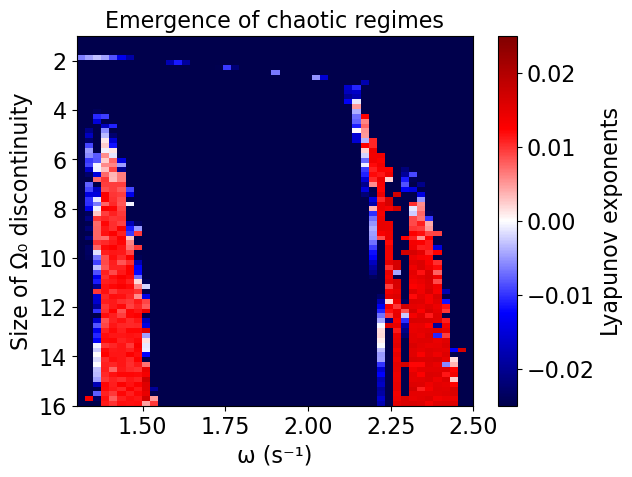

In [30]:
plt.imshow(lyap_rep,cmap = 'seismic',vmin = -0.025, vmax = 0.025, aspect = 'auto', extent = [min(w),max(w),max(W_0)/w_0,1])
cbar = plt.colorbar().set_label(label='Lyapunov exponents',size=16)
plt.title('Emergence of chaotic regimes',fontsize = 16)
#plt.ylabel('Ω₀(x<0)/Ω₀(x>0)',fontsize = 16)
plt.ylabel('Size of Ω₀ discontinuity',fontsize = 16)
plt.xlabel('ω (s⁻¹)',fontsize = 16)
#plt.savefig('FIGURA6.png')
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.show()